## Notebook 01a: Understanding the sub-SEVIR Regression ML Models 


### Goal: Interogate the pre-trained regression ML models 

#### Background 

In the [previous notebook](https://github.com/ai2es/tai4es-trustathon-2022/blob/main/severe/notebooks/Notebook_00a_Train_Regression_Models.ipynb), we trained and evaluated regression models on the sub-SEVIR dataset. In the classification notebook, we chose to evaluate the logistic regression model because it performed similarly to random forest (RF) and gradient-boosted trees (GBT) and was a linear-based model. For this notebook, we will instead focus on the best performing model which was the **GBT** model. Our goal is to better understand how this model works using explainability tools. Along the way, you'll be asked questions to test your understanding of the model and your ability to explain it to an end-user.   


<div class="alert alert-block alert-warning"><b>Optional Task: </b> Repeat the following tasks, but for the random forest (RF) and linear regression (LR). The model performances of LR and RF were comparable to GBT but did they learn the same things? To run those models, replace the estimator_name below with 'RF or 'LR'.</div>


#### Primary Tasks
1. Determine the important features.
2. Assess the learned relationships. 
3. Explain individual predictions.


#### Secondary Tasks
1. Run the skexplain code yourself and change different inputs 
2. Determine whether the model can be simplified.
3. Re-run this notebook for the RF and LR models


In this notebook, you'll notice color-coded boxes, which may provide optional tasks, questions to discuss, or warnings. Here is the color-coding breakdown: 
* <span style="color:blue">Blue Box</span> = Question to discuss
* <span style="color:red">Red Box</span> = Warning/Caution
* <span style="color:gold">Yellow Box</span> = Optional task to perform 
* <span style="color:green">Green Box</span> = Useful Tip or Reminder



In [14]:
# Add ../scripts to our path so we can import functions from there.
import sys,os
sys.path.append('../scripts')        
from util import load_ml_data
from verification import plot_verification
from plotting_config import display_feature_names, color_dict

### Import the neccesary thrid-party packages

In [15]:
#needed packages 
import numpy as np
import pandas as pd
import joblib
import skexplain
import shap

### Load the data. 

The data has been pre-split into training, validation, and testing datasets. 

In [16]:
# Load the data.
X_train, y_train, X_val, y_val, X_test, y_test = load_ml_data(task='regression')

### Load the ML models. 

For this tutorial, we will load the two tree-based models (Gradient-Boosted Tree) and a logistic regression model that was trained on the SEVIR dataset. 


<div class="alert alert-block alert-warning"><b>Optional Task: </b> A random forest, gradient-boosted tree and linear regression model have been pre-trained on this dataset for this tutorial. For an advanced option, you can train an ML model yourself (multiple options available in scikit-learn). To use that model change the code below to load your model instead. See our regression notebook for examples of training an ML model with this dataset.</div>

In [17]:
# Load the pre-trained ML models into the skexplain format (estimator name, estimator)
estimator_name = 'GBT'
estimators = [(estimator_name, joblib.load(f'../models/{estimator_name}_regression.joblib'))]

## Task 1. Analyze the Important Features 

An initial task for understanding an ML model is understanding the important features – those features that contribute most to the model's performance. If the model performs well on independent data, then these features might provide insight into the data-generating process. The common approach for assessing feature importance is the permutation importance method. There are different flavors of permutation importance, which were covered in the lecture series. For this tutorial, we will use four versions of permutation importance to understand the top predictors: 

* Backward Single-pass
* Backward Multi-pass
* Forward Single-pass
* Forward Multi-pass

It is crucial to evaluate multiple explainability methods as no single method has been found to perform significantly better than another method. Our task is to summarize the different rankings and hopefully improve our estimate of the top features. 


When explaining global characteristics of a model like top features and/or learned relationships, we want to use the training dataset. The goal of measuring feature importance or learned relationships is to quantify how the model relies on each feature and not how well the model generalizes to unseen data. If the ML model learned a pattern in the training dataset that it is underrepresented in the independent dataset it can bias the feature ranking. For example, imagine we had an ML model trained to predict subfreezing road surface temperatures. If the ML model learned that frozen road surfaces only occur when 2-m temperatures are $<$ -10 $^{\circ}$C, but the independent dataset is mainly composed of 2-m temperature samples between -5--0$^{\circ}$C, then 2-m temperature would have reduced importance. Therefore, the feature importances and the learned relationships in this tutorial are evaluated using the training dataset.

In [18]:
# Initialize the ExplainToolkit
explainer = skexplain.ExplainToolkit(estimators, X_train, y_train)

### Task 1a. (optional) Run the skexplain code yourself. 

For more information on the permutation importance in scikit-explain, check out this [tutorial] (https://github.com/monte-flora/scikit-explain/blob/master/tutorial_notebooks/permutation_importance_tutorial.ipynb). Play around with `subsample` size or the `evaluation_fn` used. Is there any sensitivity? 

In [21]:
# Load the permutation importance results.
# Change metric if you choose to run a different loss equation. 
metric = 'mse'
results_backward = explainer.load(f'../datasets/perm_imp_backward_{metric}_{estimator_name}.nc')
results_forward = explainer.load(f'../datasets/perm_imp_forward_{metric}_{estimator_name}.nc')

### Plot the Important Features. 

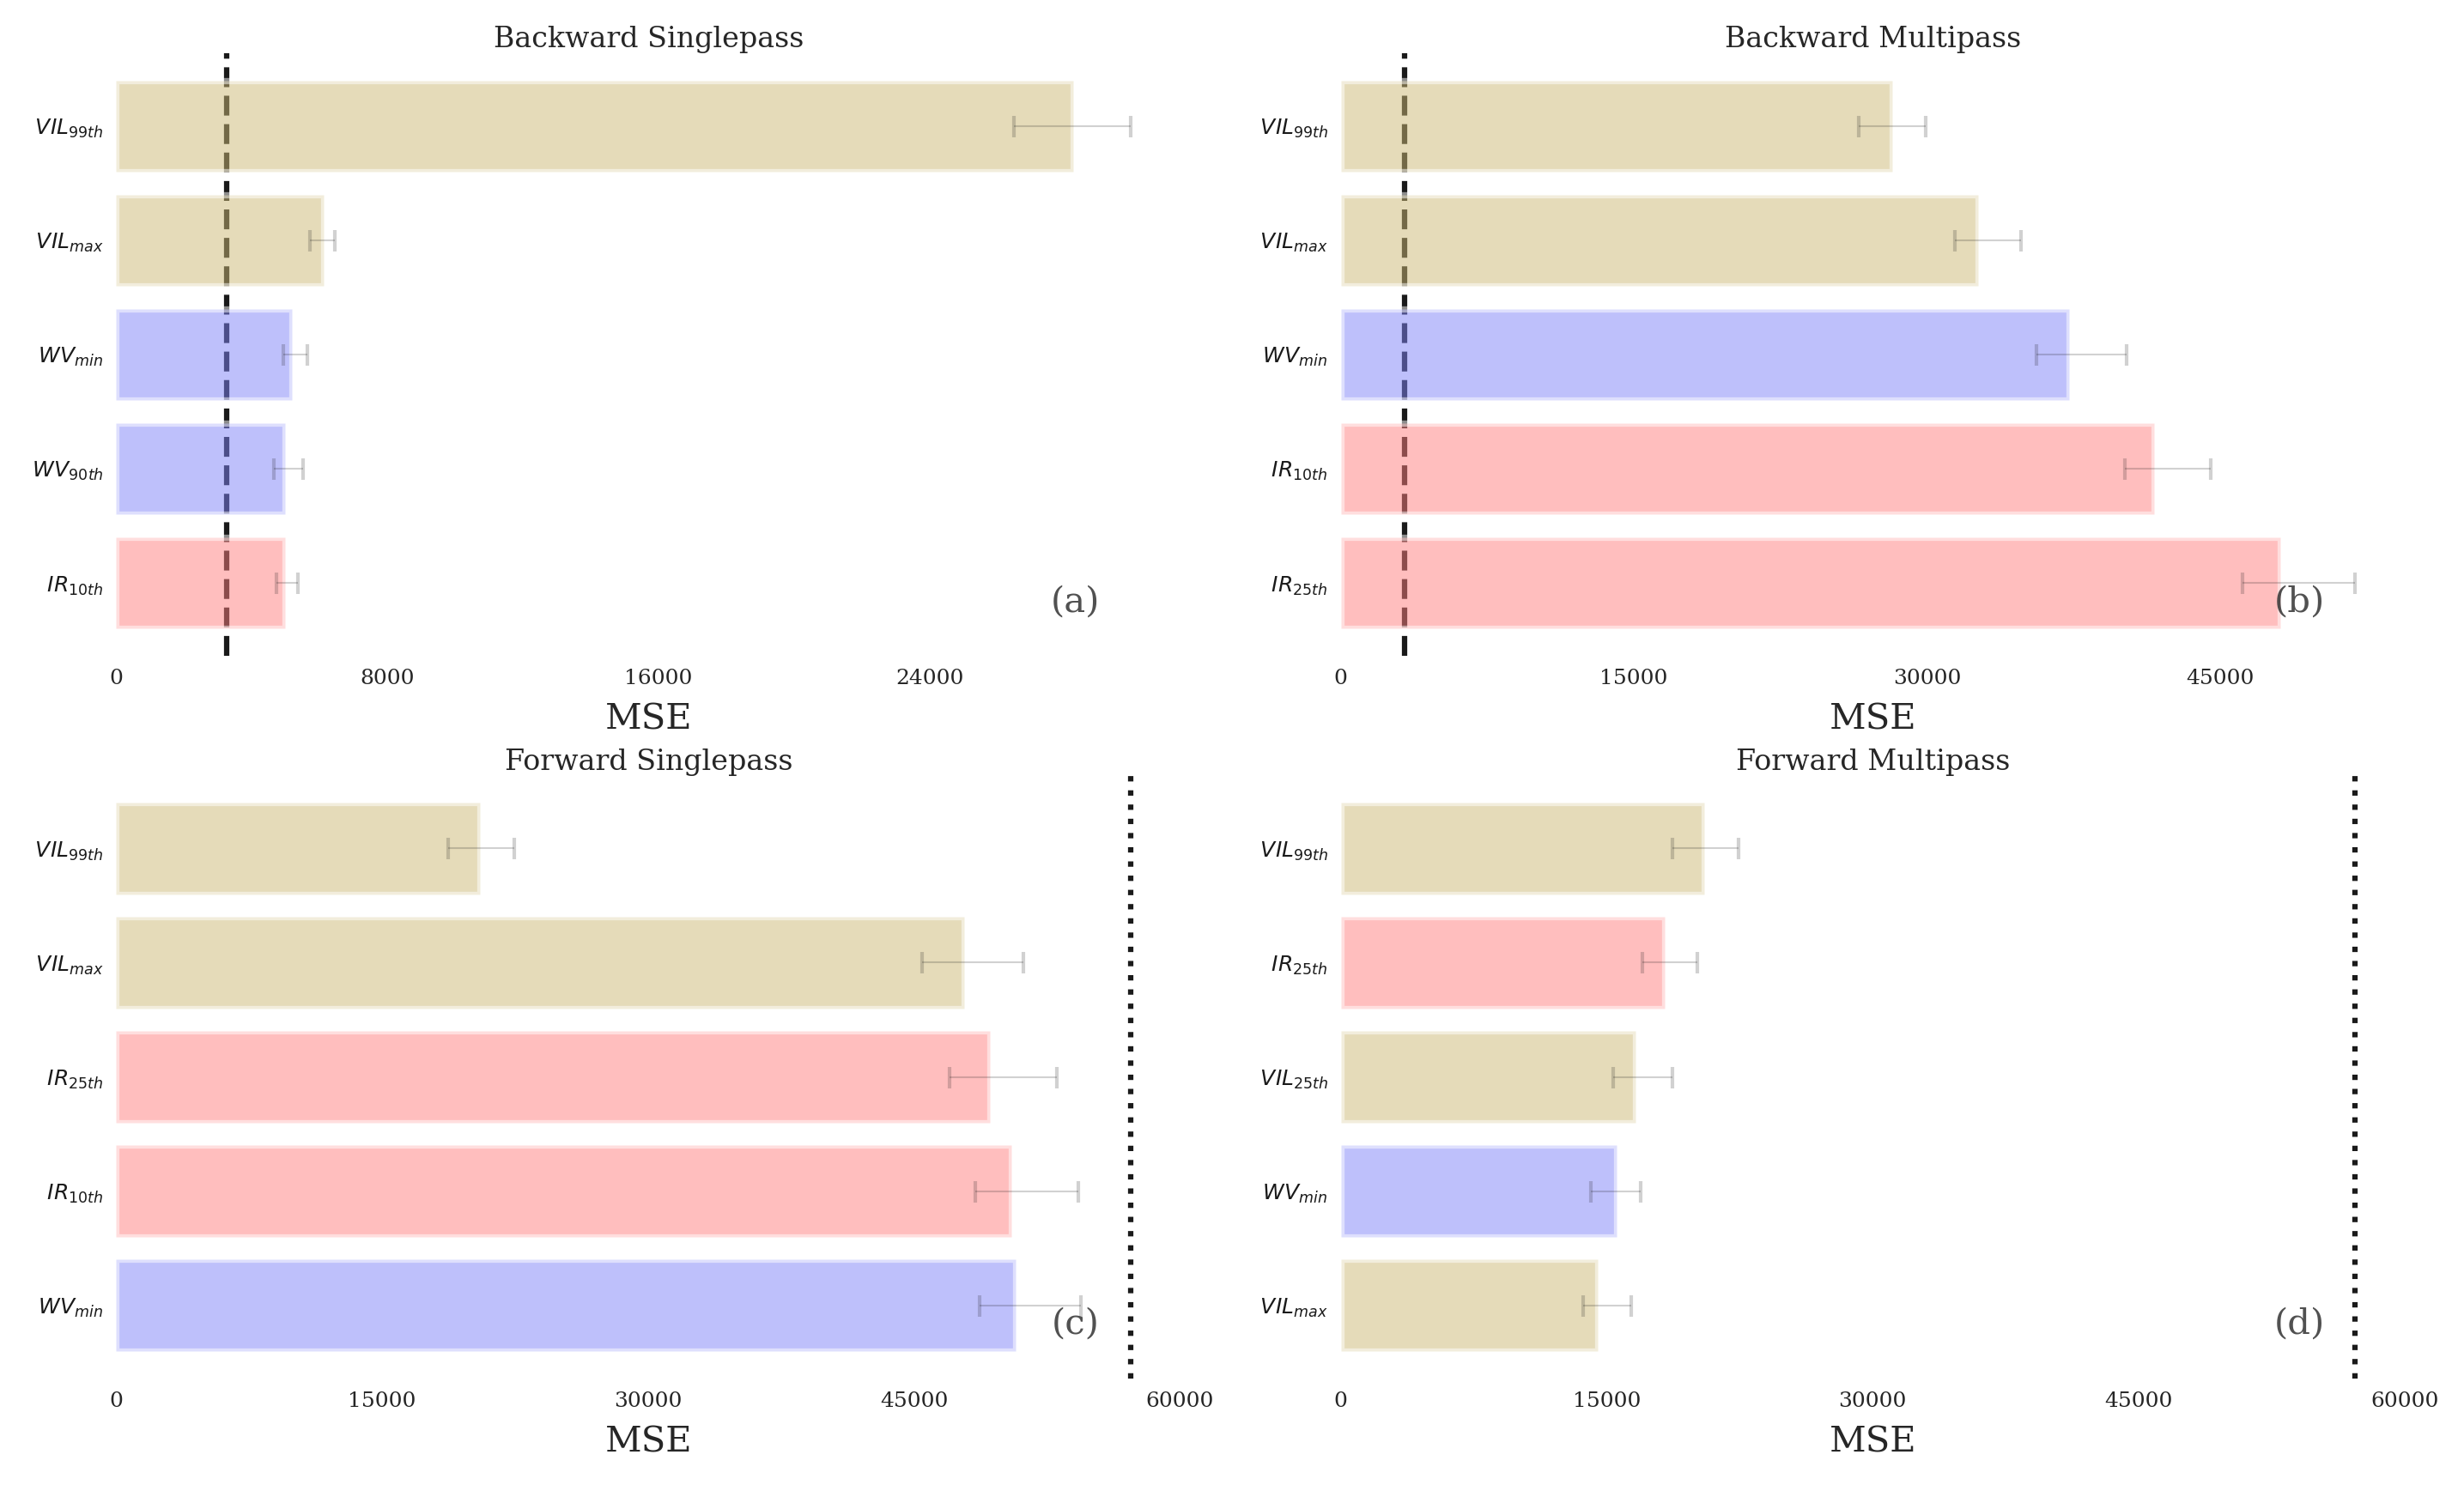

In [7]:
import itertools
explainer = skexplain.ExplainToolkit(estimators, X_train, y_train)

types = ['backward_singlepass', 'backward_multipass', 'forward_singlepass', 'forward_multipass'
]
titles = [t.replace('_', ' ').title() for t in types]
panels = [(t, n) for n,t in itertools.product([estimator_name], types)]

fig,axes = explainer.plot_importance(data=[results_backward, results_backward, 
                                           results_forward, results_forward], 
                                panels=panels,
                                num_vars_to_plot=5,
                                xlabels=[metric.upper()]*len(panels),
                                display_feature_names=display_feature_names, 
                                feature_colors=color_dict, 
                                n_columns=2, 
                                figsize=(10,6),
                                 )

for ax, title in zip(axes.flat, titles):
    ax.set_title(title, pad=0.02)

The color coding is as follows: 
1. Red : Infrared (IR) brightness temperature-based features
2. Purple: Water vapor (WV) brightness temperature-based features
3. Gold: Vertically integrated liquid (VIL)-based features

For 3 out of the 4 permutation importance methods,  spatial-99th percentile VIL (VIL$_{99th}$) and maximum VIL (VIL$_{max}$) were the top 2 features. Conversely, for the classification models, all four permutatiom importance methods agreed on the top 2 features. In this case, the forward multipass found that VIL$_{99th}$ and spatial-25th percentile IR temperature (IR$_{25th}$) were the top 2 features. Recall that for the forward permutation importance methods, all features start jointly permuted and are un-permuted to assess how model performance improves. Thus, the forward multipass suggest thats if only VIL$_{99th}$ and IR$_{25th}$ were unpermuted, they produce the best model performance as opposed to any other combo with VIL$_{99th}$. 

<div class="alert alert-block alert-info"><b>Question 1: </b> How does the disagreement between the methods impact your trust in the explanation? How do you think this would impact you end user's trust in the model overall? </div>

Unfortunately, when features are correlated with each other it complicates the interpretation of the results. Since the dataset is composed of multiple spatial percentile of the same variable, there will be strong linear correlations between features. For example,  VIL$_{99th}$ and VIL$_{max}$ are correlated with each other (which isn't surprising). This calls into questions whether VIL$_{99th}$ and/or VIL$_{max}$ have biased ranks due to the correlation between them. 

In the next cell, we plot the correlation coefficient matrix to evaluate the relationship between features. 

this method is deprecated in favour of `Styler.format(precision=..)`


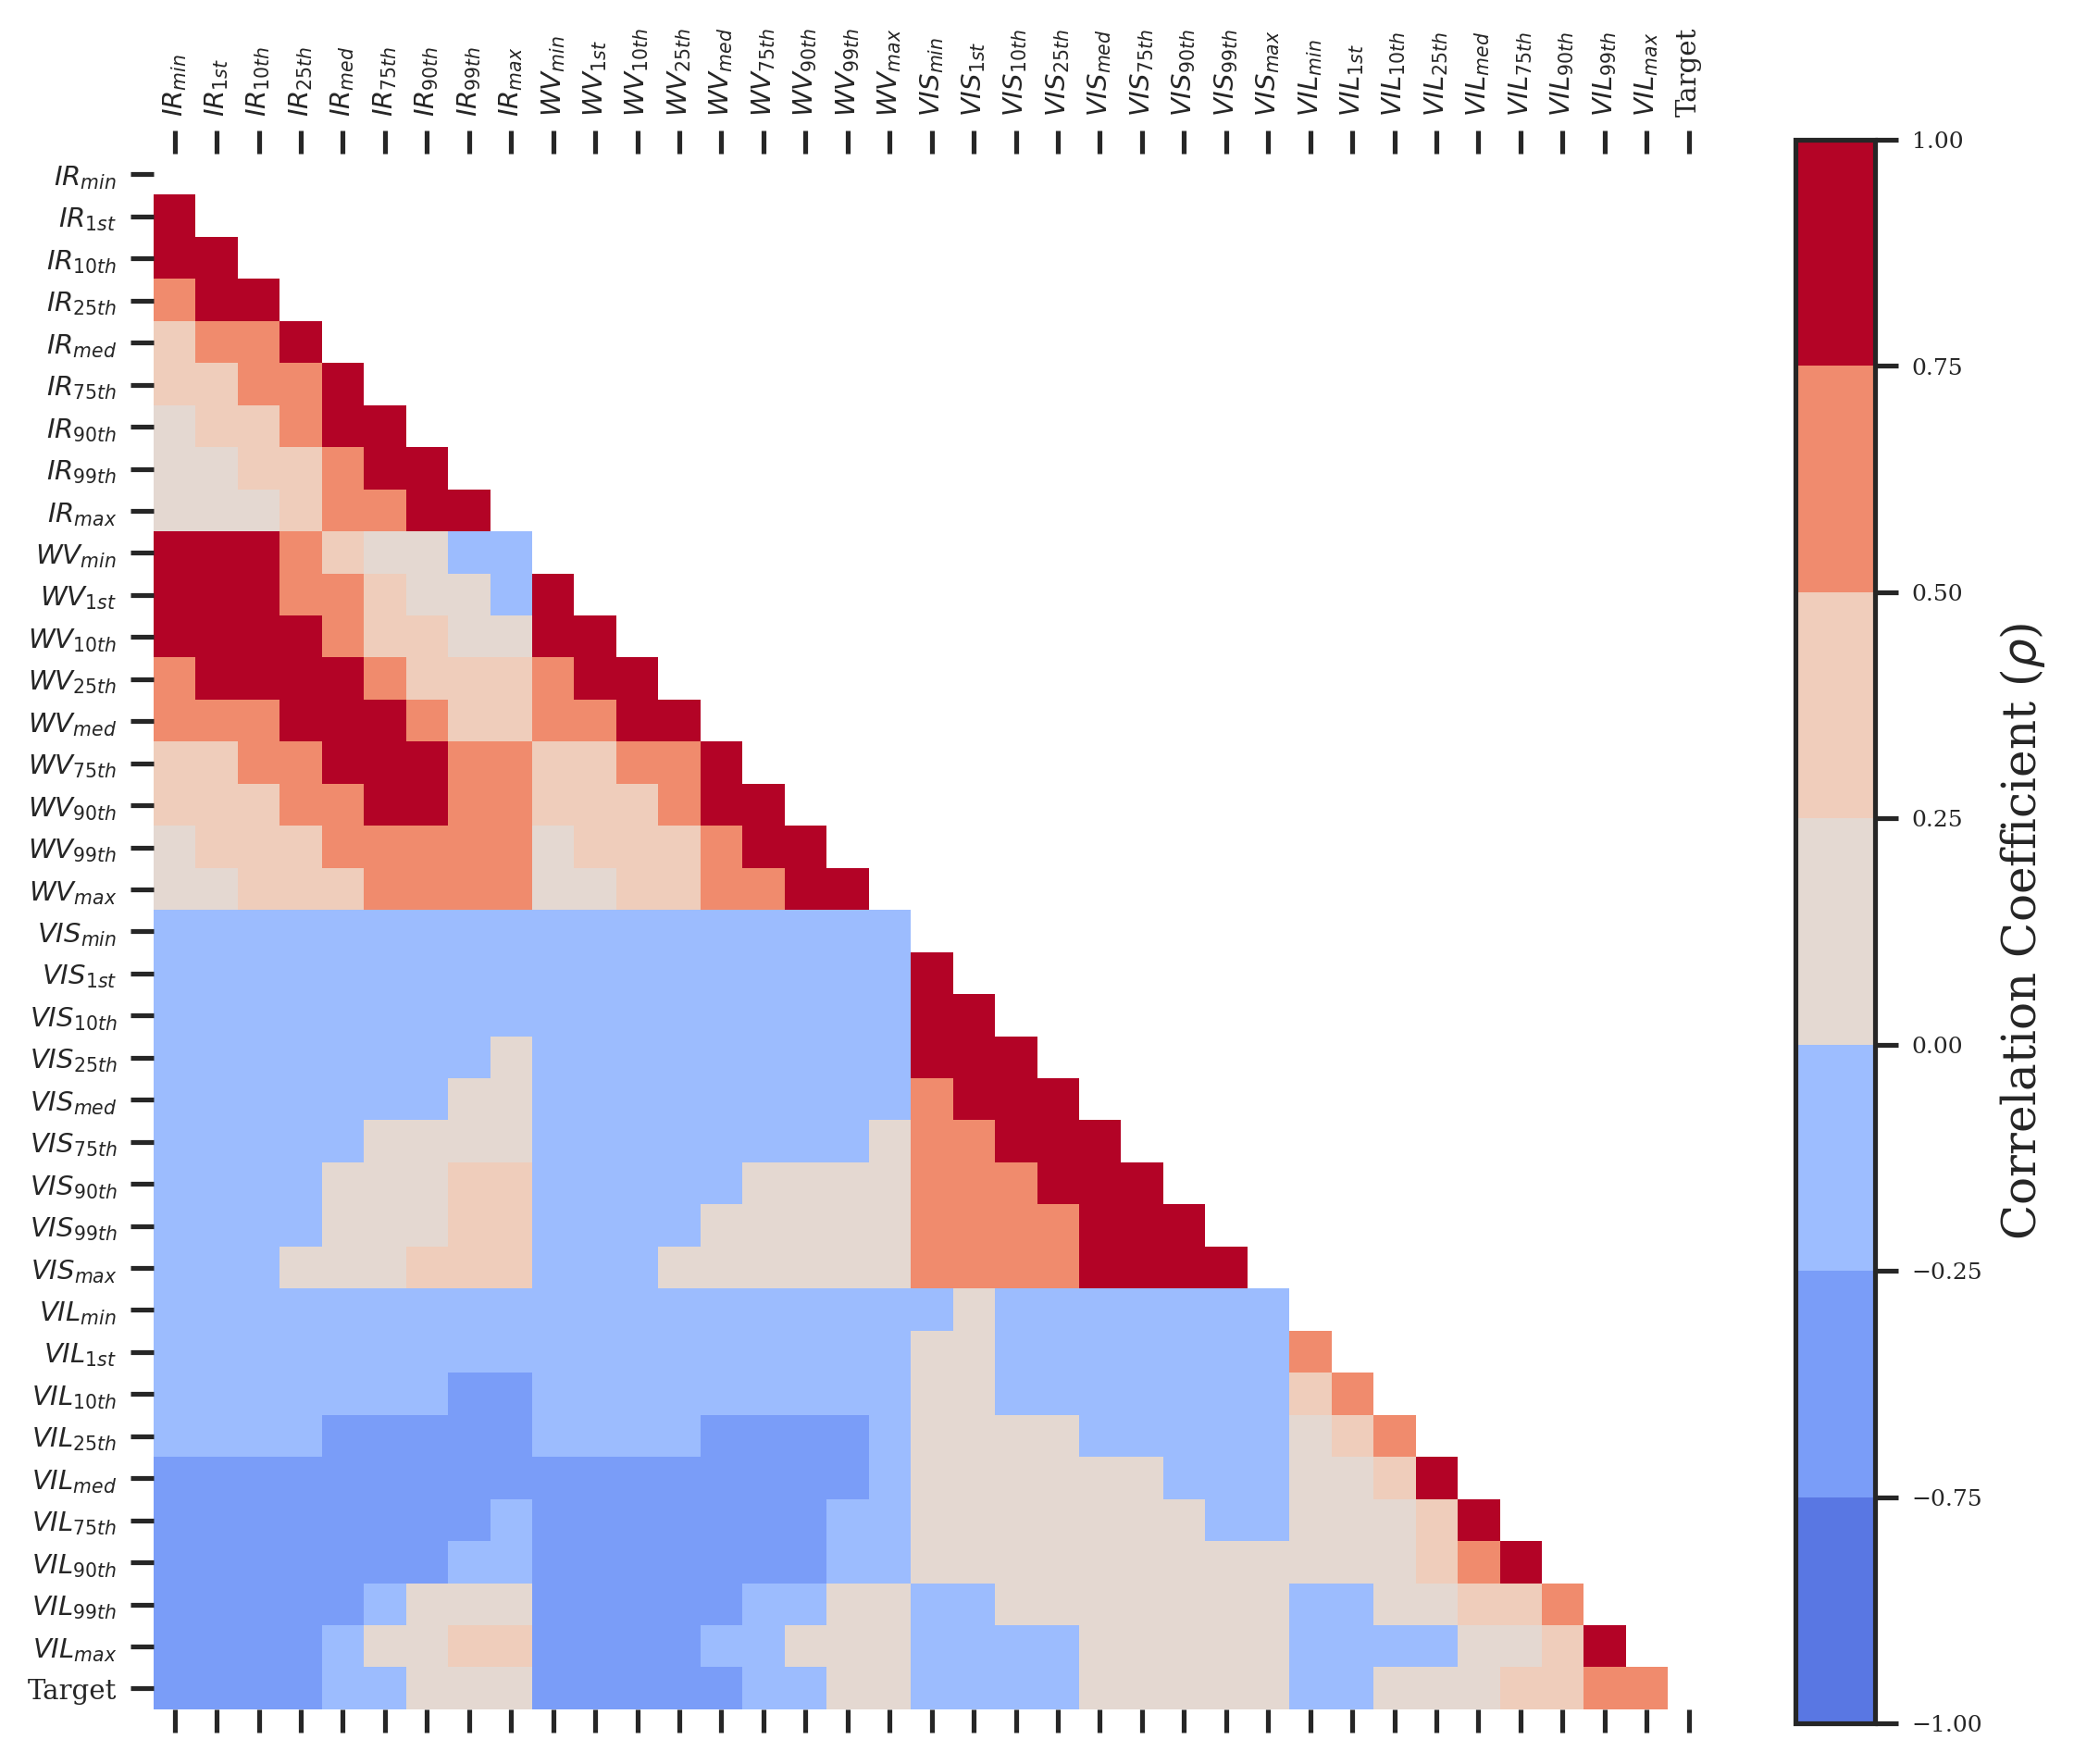

In [8]:
# Change this cell back to 'Code' to see the correlation coefficient matrix. 

import matplotlib.pyplot as plt
from matplotlib.colors import from_levels_and_colors

X_renamed = X_train.rename(mapper=display_feature_names, axis=1)
X_renamed['Target'] = y_train
corr = X_renamed.corr()

mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr[mask] = np.nan
(corr
 .style
 .background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
 .highlight_null(null_color='#f1f1f1')  # Color NaNs grey
 .set_precision(2))

fig, ax = plt.subplots(figsize=(8, 8), dpi=300)

nice_cmap = plt.get_cmap('coolwarm')
# Pick some of the nicer colors from the palette...
colors = nice_cmap([ 25, 50, 75, 135, 150, 200, 300, ])
levels = [-1.0, -0.75, -0.25, 0, 0.25, 0.5, 0.75, 1.0]

cmap, norm = from_levels_and_colors(levels, colors,)

c = ax.matshow(corr, cmap=cmap,norm=norm)
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90, fontsize=7)
plt.yticks(range(len(corr.columns)), corr.columns, fontsize=7)
plt.colorbar(c, label=r'Correlation Coefficient ($\rho$)', fraction=0.046)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

As stated above, for a particular variable, its different spatial percentiles are decently correlated with each other. There is not much correlation between variables expect IR and WV temperatures. In fact, for certain spatial percentiles, IR and WV temperatures are highly correlated. 

<div class="alert alert-block alert-warning"><b>Optional Task: </b> Given the correlations between IR and WV brightness temperatures, can we remove one of them and maintain similar model performance. How will this impact the model explainability? Use the methods from the regression notebook to train an ML model with the reduced feature set.</div>

<div class="alert alert-block alert-info"><b>Question (optional): </b> What are the top predictors if remove IR- or WV-based features? </div>

## Task 2. Analyze the Learned Relationships

To evaluate the learned relationships we use the accumuluted local effects rather than partial dependence.
For more details on the accumulated local effects, see this [tutorial notebook](https://github.com/monte-flora/scikit-explain/blob/master/tutorial_notebooks/accumulated_local_effect_tutorial.ipynb).


In [9]:
# Get the important features from both the backward and forward perm. imp. results.
important_vars = []
for results in [results_backward, results_forward]:
    v = explainer.get_important_vars(results_backward, n_vars=2)[estimator_name]
    important_vars.extend(v)

# Keep the unique features 
important_vars = list(set(important_vars))
    
# Compute the ALE 
ale_1d_ds = explainer.ale(features=important_vars, subsample=0.25, n_jobs=2, n_bins=20, )

  0%|          | 0/5 [00:00<?, ?it/s]

(<Figure size 1800x1200 with 12 Axes>,
 array([[<AxesSubplot:xlabel='$IR_{25th}$'>,
         <AxesSubplot:xlabel='$WV_{min}$'>,
         <AxesSubplot:xlabel='$VIL_{max}$'>],
        [<AxesSubplot:xlabel='$VIL_{99th}$'>,
         <AxesSubplot:xlabel='$IR_{10th}$'>, <AxesSubplot:>]], dtype=object))

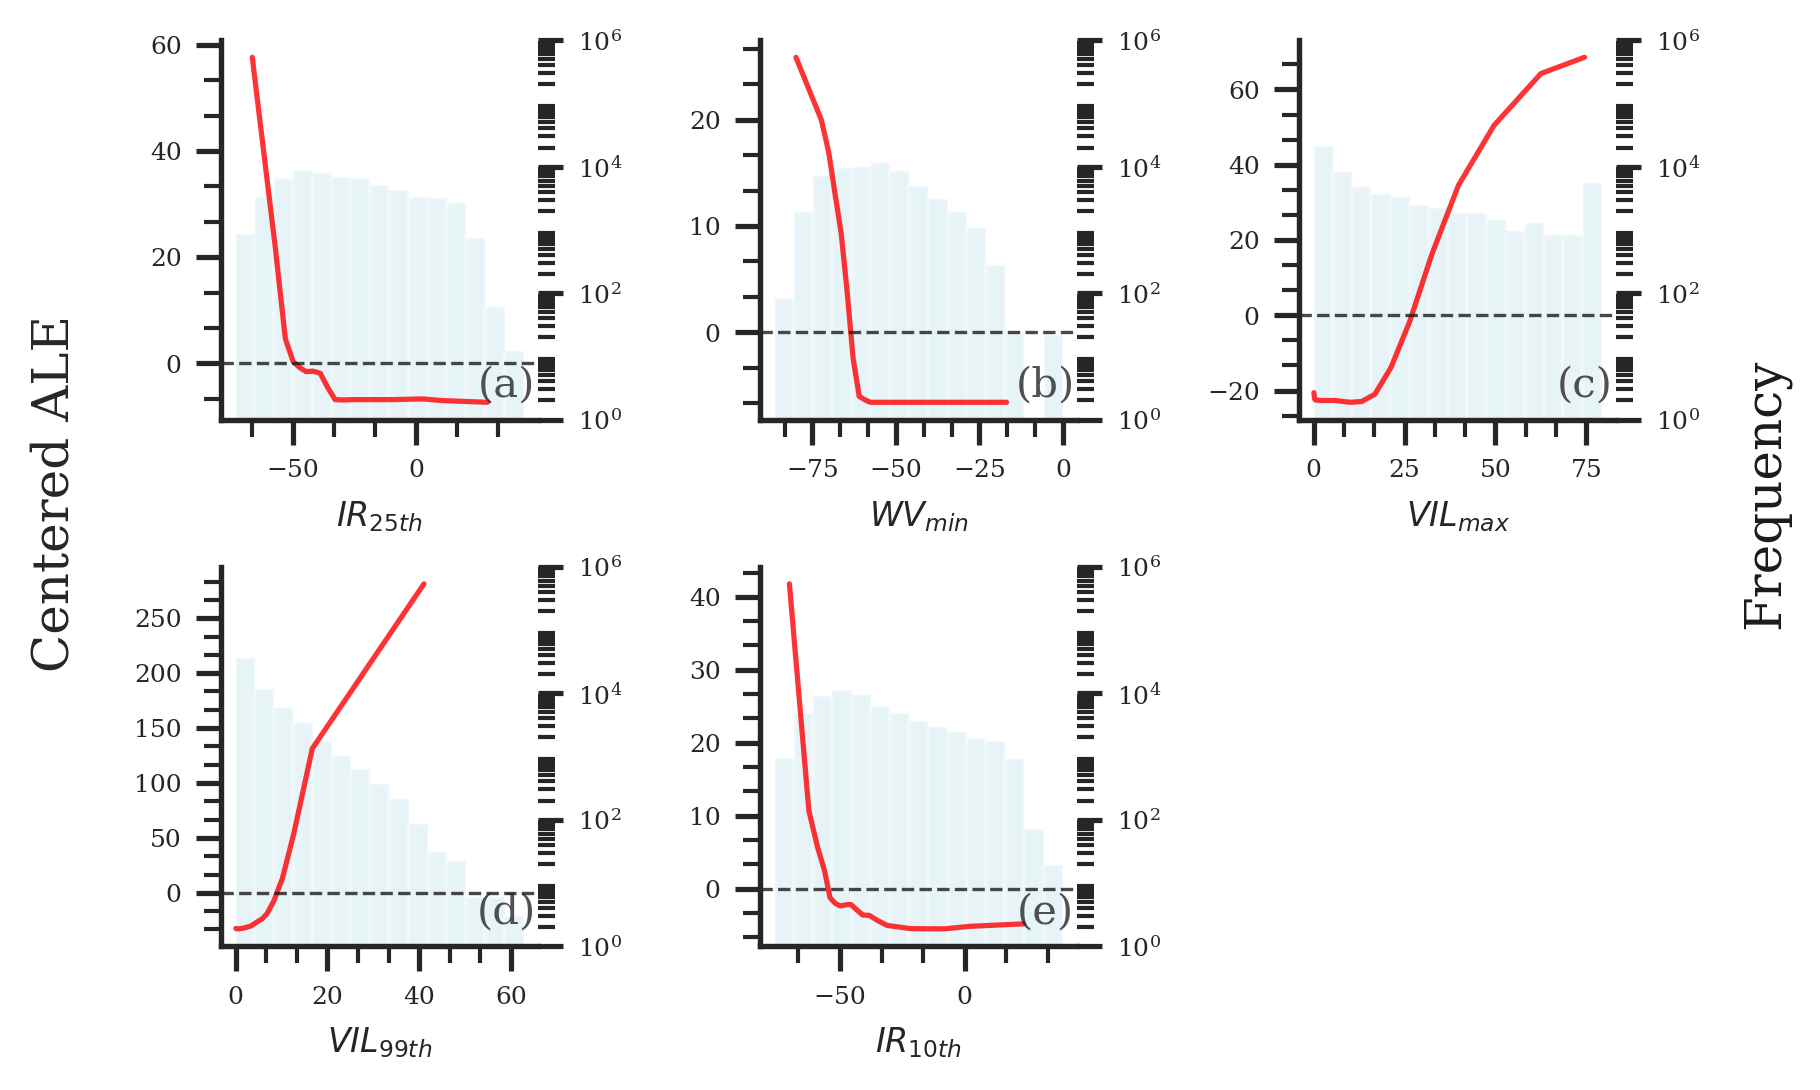

In [10]:
explainer.plot_ale(ale_1d_ds, display_feature_names=display_feature_names, figsize=(6,4))

The importance of VIL$_{99th}$ (panel e) to the GBT model is understandable as we can see that slight increases in VIL$_{99th}$ lead to substantial changes in the number of flashes. For example, VIL$_{99th}$ $\approx$ 15 has zero impact on the model prediction, but VIL$_{99th}$ $\approx$ 20 increases the flash amount by 150 on average. A higher VIL$_{99th}$ indicates a greater region of high VIL values, so it is plausible that the lightning flash amount would increase. The sensitivity to the other top features is more modest. For example, unless the spatial-10th percentile IR (panel a) temperature is below -50 C (i.e., larger region of cooler temperatures aloft), the model prediction is insensitive to this feature (constant negative contribution).

We can see that the possible contributions from VIL$_{max}$ (panel c) and IR$_{25th}$ (panel b) are similar. We know from the correlation coefficient matrix above that IR$_{25th}$ is highly correlated with WV whereas VIL is fairly uncorrelated with the other features. Thus, when permuted even if IR$_{25th}$ and VIL$_{max}$ were equally important, the backward-based permutation importance methods would tend to rank IR$_{25th}$ lower as the model could rely on the WV predictors. For the forward-based methods, however, WV is permuted when assessing the importance of IR$_{25th}$, so it can be ranked higher. This example highlights the difficultly of understanding models with strongly correlated features.  

<div class="alert alert-block alert-info"><b>Question 2: </b> How do think the correlation between the IR- and WV-based features would impact your explanation of the model? And how would you explain this to your end user? </div>


<div class="alert alert-block alert-info"><b>Question 3: </b> Given that the number of lightning flashes can only be positive value, can you explain the negative ALE values? </div>

## Task 4. Explain individual predictions

In Task 1 and Task 2, we explored global charactersistic of the model. VIL$_{99th}$ was the top feature, but there was only partial consistency on the remaining top features. The relationships for the top features were plausible. In the following example, we will use Shapley values to breakdown how each feature contributes to a single model prediction. 

Unlike the global explainability, we are free to use the training or testing dataset for local explainability. For this task, we switch to testing dataset for the following examples.

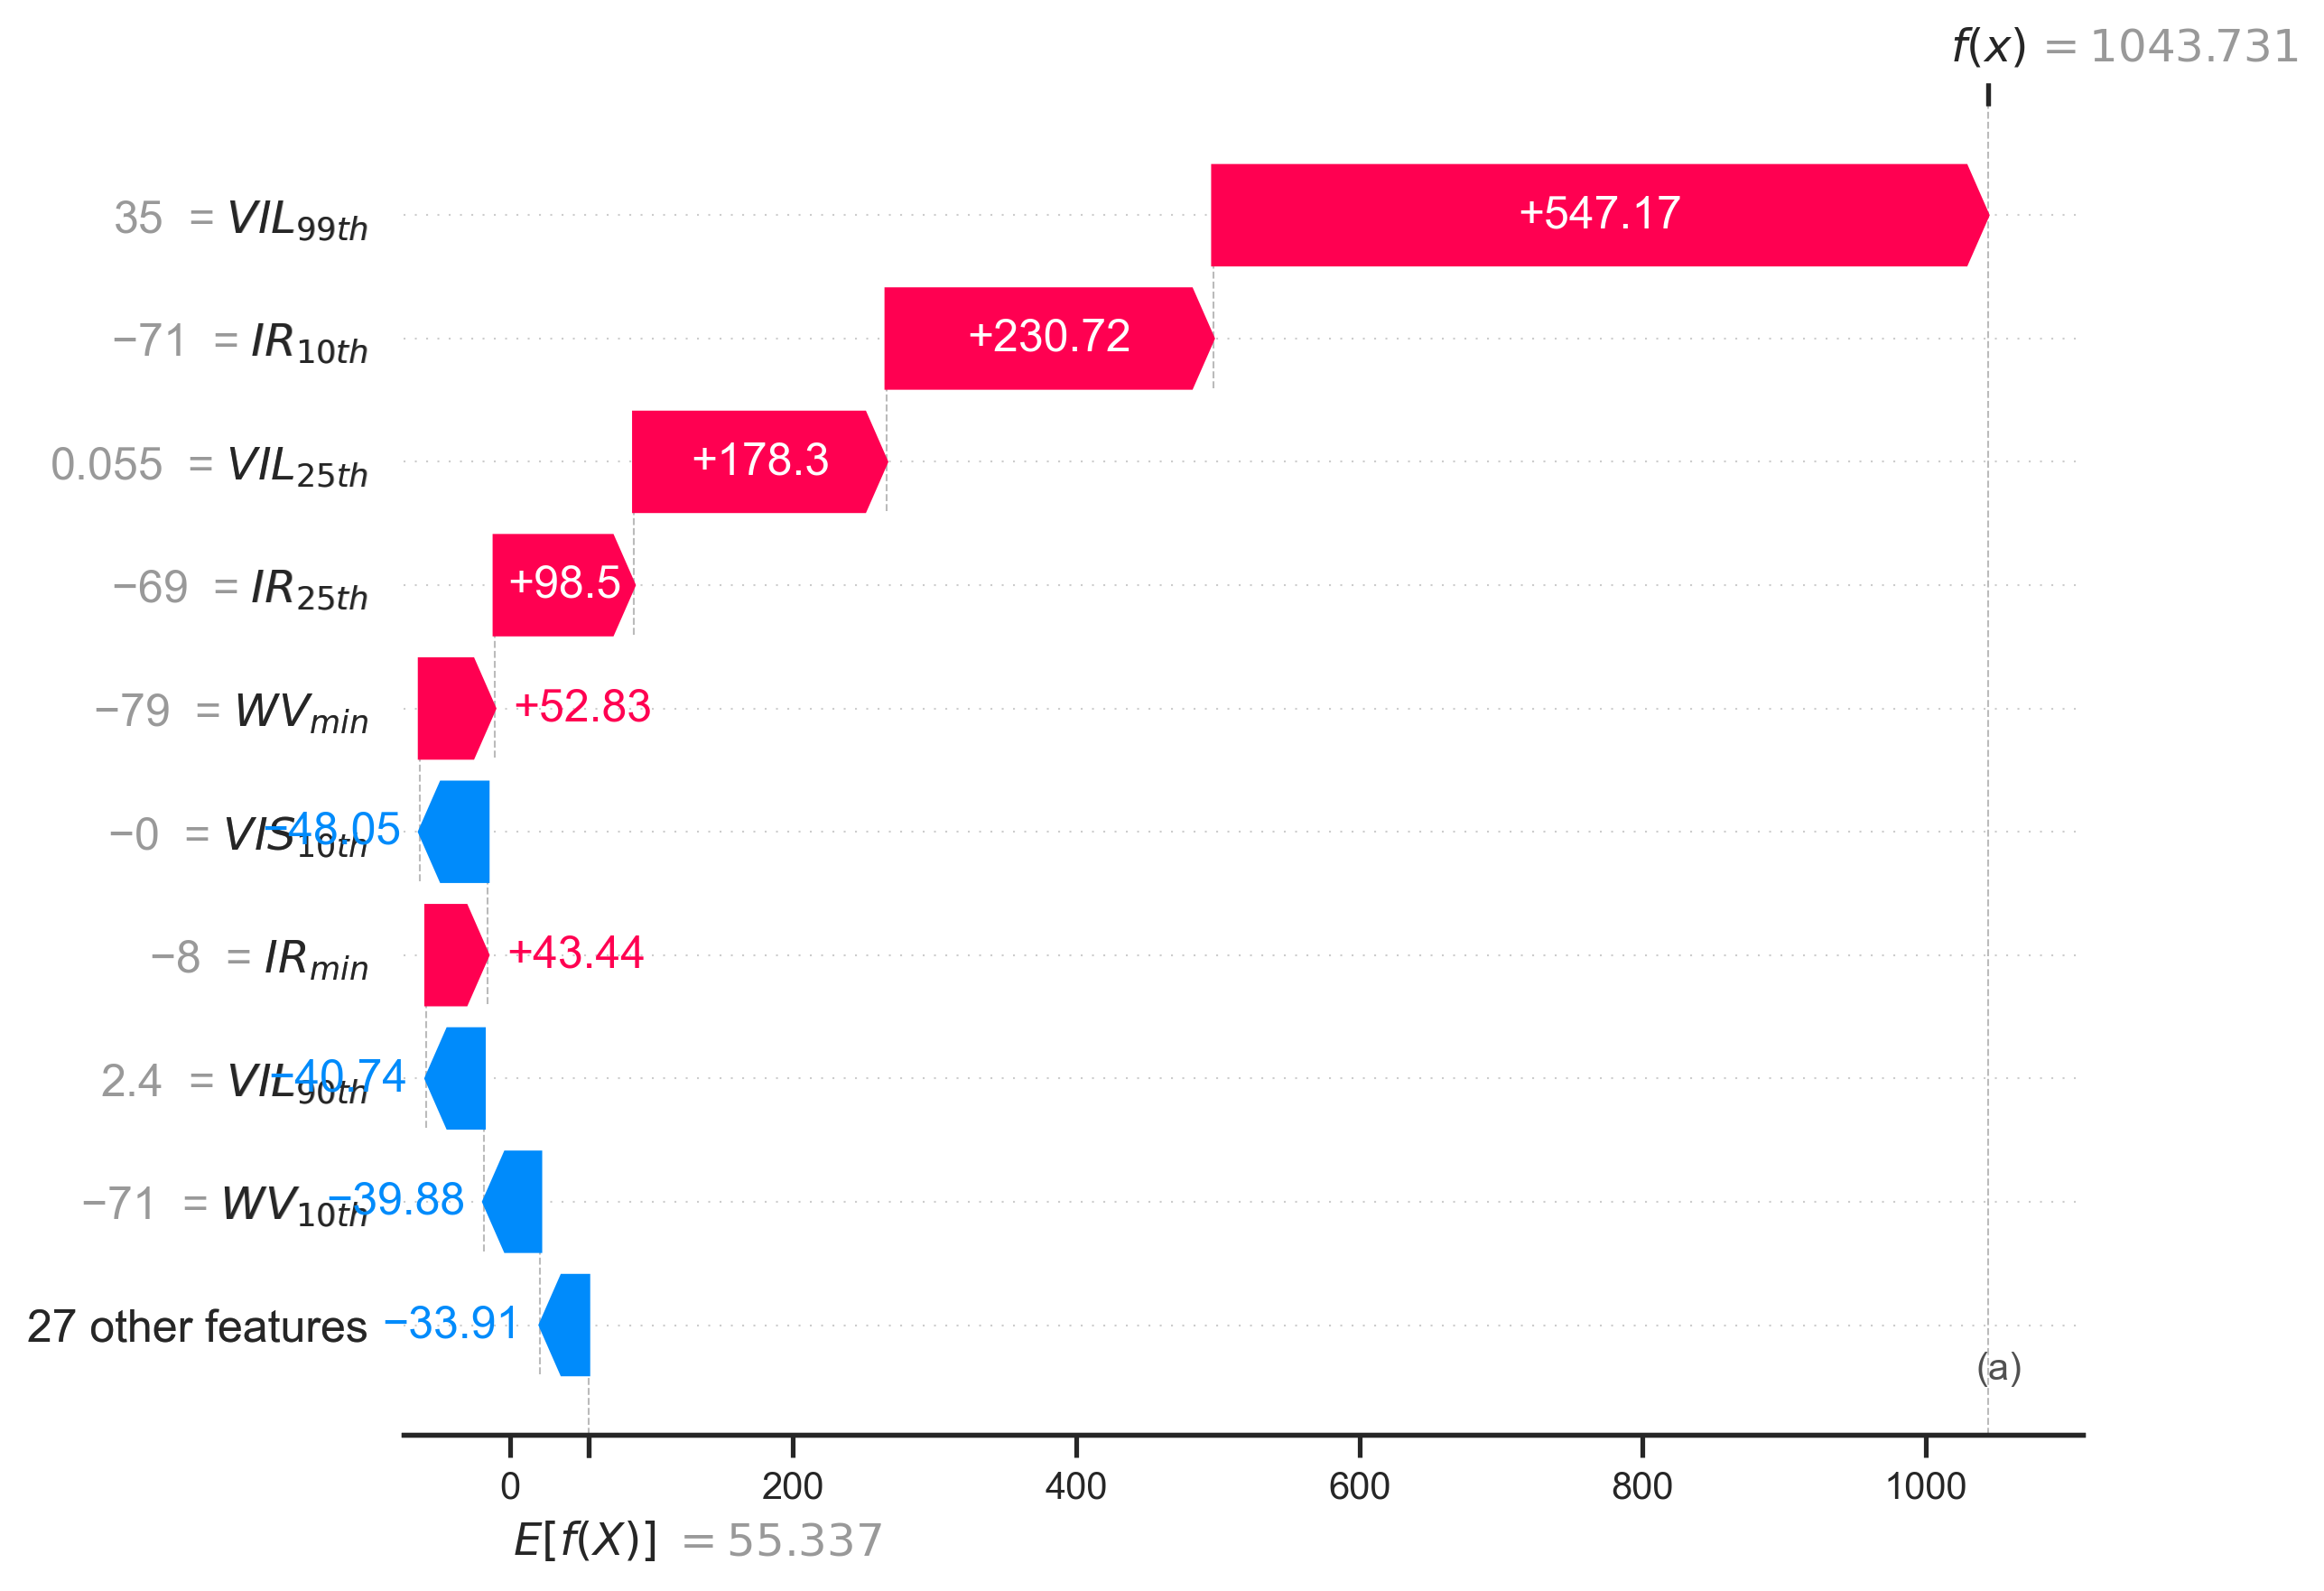

In [11]:
from skexplain.common.contrib_utils import get_indices_based_on_performance

# This code from skexplain finds 'n_samples' of the 'Least Error Predictions' and 'Most Error Predictions'
inds = get_indices_based_on_performance(estimators[0][1], X_test, y_test, 
                                        estimator_output='raw', n_samples=500)

# Let's use the last worst miss. We want a more marginal miss rather than 
# a worst case miss. 
idx = inds['Most Error Predictions'][-1]

explainer = skexplain.ExplainToolkit(estimators, X_test.iloc[[idx]], [y_test[idx]])

results = explainer.local_contributions(method='shap',
                                        performance_based=False,
                                       shap_kwargs={'masker' : 
                                      shap.maskers.Partition(X_train, 
                                                             max_samples=100, clustering="correlation"), 
                                     'algorithm' : 'exact'}
                                          )

fig = explainer.plot_contributions(contrib=results,  
                            display_feature_names=display_feature_names,
                        )

In the upper right hand size, we can see the predicted number of flashes is 1043. The VIL$_{99th}$ and IR$_{10th}$ contribute 777 (=547+230) to that number of flashes. However, the true number of flashes for this example was 2588. We grossly underestimated the number of flashes by over 1000! In the next cell we provide an animation of this example. As we can see there are a number of issues that might be negatively affecting the prediction. First, the convective core are quite wide and associated with a large number of flashs per core. The features for the models used in this tutorial are limited and do not consider these details, so it is not surprising the ML model would underpredict the lightning flash amount. It is useful to determine failure modes as we may be leverage them when conveying uncertainty in our predictions. Second, we can see that there is missing data in the water vapor channel (ir069; the horizontal blue bar). Lastly, these storms occurred during the night time and thus the visible channel is empty, which may be negatively biasing the prediction. 


<div class="alert alert-block alert-info"><b>Question 4: </b> How does learning about the limitations of the model impact your notions about the model?  </div>


<div class="alert alert-block alert-info"><b>Question 5: </b> How would you modify your model evaluations knowing that convective core size is a possible failure mode? </div>

<div class="alert alert-block alert-info"><b>Question 6: </b> How would you explain your answers to Q4 and Q5 to your end user? </div>


<div class="alert alert-block alert-success"><b>Tip: </b> The following animations were made using a Google colab notebook </div>

[Click here](https://colab.research.google.com/drive/1Td7JatUP4SmuDt7TX3fE3sfbEG8Rxz2r#scrollTo=x1_jAyZ8ExQG) to access the notebook. In the "Find Storm" cell, you can enter the example index you want to examine and whether the example comes from the training or testing dataset. The "view movie" cell will then create an animation in time of that example. 


In [12]:
from IPython.display import Video
Video("undercount.mp4")